### Import libraries

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import logging
import optuna
import json

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from boruta import BorutaPy
from numpy import sqrt 

pd.set_option('display.max_columns', None)  
sns.set_theme(style="whitegrid")

### Read dataset

In [2]:
df = pd.read_csv('data/dataset_v3.csv')

### Split into train and test

In [3]:
# Calculate the number of unique dates that correspond to 20% of the dataset
num_dates = int(df['date'].nunique() * 0.2)

# Get the date that splits the data into 80% training and 20% testing
split_date = df['date'].unique()[-num_dates]

# Splitting the dataset
train = df[df['date'] < split_date]
test = df[df['date'] >= split_date]

X_train = train.drop(columns=['pageviews_-1d_lag', 'offer_id', 'date'])  # Dropping 'date' as it's not a feature
y_train = train['pageviews_-1d_lag']

X_test = test.drop(columns=['pageviews_-1d_lag', 'offer_id', 'date'])
y_test = test['pageviews_-1d_lag']

### Let's see how are we comparing to a baseline model before we perform hypertuning

In [4]:
lgbm_model = lgb.LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = sqrt(mse_lgbm)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f'LightGBM Regression - RMSE: {rmse_lgbm}, MAE: {mae_lgbm}, R²: {r2_lgbm}')

LightGBM Regression - RMSE: 215.1892656277834, MAE: 33.26309051244499, R²: 0.6859516019899189


### Hypertuning

I chose Optuna for hyperparameter tuning due to its efficiency, automated search space exploration, pruning capabilities, seamless integration, progress monitoring and configurability. 

This simplifies and accelerates the hyperparameter optimization process.

In [5]:
# Configure the logging
logging.basicConfig(level=logging.INFO, filename='hypertuning/optuna_logs.txt', filemode='a')
logger = logging.getLogger(__name__)

def objective(trial):
    # create the LightGBM model
    gbm = lgb.LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        learning_rate=trial.suggest_float('learning_rate', 1e-6, 1e-0),
        num_leaves=trial.suggest_int('num_leaves', 2, 150),
        max_depth=trial.suggest_int('max_depth', 1, 100),
        subsample=trial.suggest_float('subsample', 0.01, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0),
        reg_alpha=trial.suggest_float('reg_alpha', 0.01, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-4, 1),
        min_split_gain=trial.suggest_float('min_split_gain', 1e-9, 1e2),
        random_state=42,
        metric='l2',    # Mean Squared Error (MSE)
        verbose=-1
    )

    # fit the model
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    
    # Log the results
    logger.info(f"Trial {trial.number} - RMSE: {rmse}, Hyperparameters: {trial.params}")
    return rmse

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=600, show_progress_bar=True)

C:\Users\Mihigh\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/600 [00:00<?, ?it/s]

Save the candidate parameters in json files.

In [6]:
# Save the results
with open(f'hypertuning/best_params.json', 'w') as f:
    json.dump(study.best_params, f)
    
params = study.best_params
print(study.best_params)

{'n_estimators': 173, 'learning_rate': 0.018011774390702603, 'num_leaves': 125, 'max_depth': 56, 'subsample': 0.07855032863600003, 'colsample_bytree': 0.26542255346004306, 'reg_alpha': 0.9779312450176652, 'reg_lambda': 0.7170224140564138, 'min_split_gain': 24.767406897306707}


Check the results using obtained parameters.

In [7]:
gbm = lgb.LGBMRegressor(**params, random_state=42, metric='L2')
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

Visualize the metrics.

In [8]:
# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)  # Calculate R-squared

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared (R²): {r_squared}')  # Print R-squared

RMSE: 167.1691996197067
MSE: 27945.541301493344
MAE: 32.07347701198032
R-squared (R²): 0.8104743906048557


Looks like we didn't obtain the most promising results, but there are definitely ways to improve them. Let's take a look over all the variables of our problem.

Let's examine the contribution of each feature, which is determined by averaging the estimates across the ensemble of estimators.

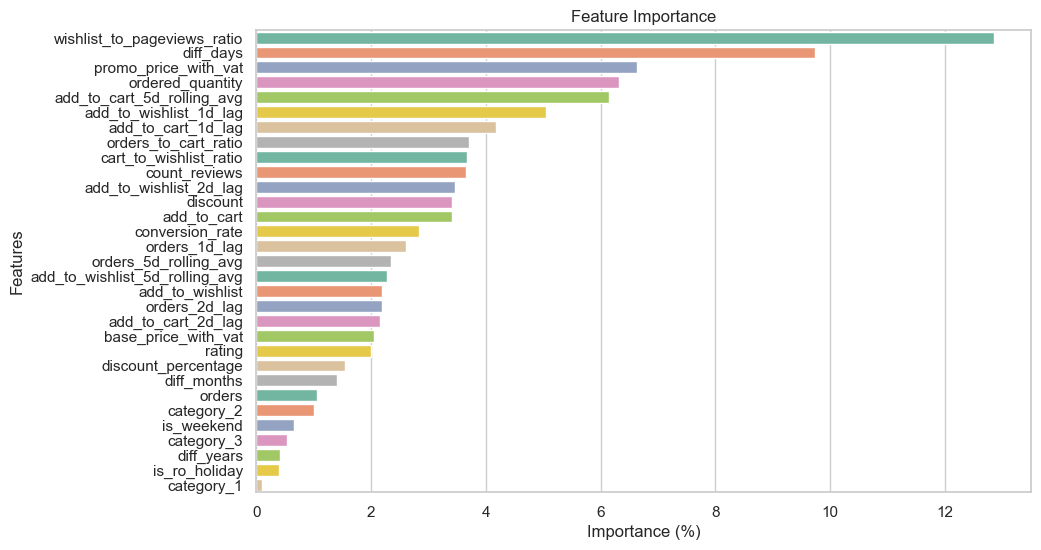

In [9]:
# Get feature importances and create a DataFrame for visualization
feature_importance = gbm.feature_importances_

# Calculate percentage importance
total_importance = sum(feature_importance)
percentage_importance = (feature_importance / total_importance) * 100

features = pd.DataFrame({'Feature': X_train.columns, 'Importance': percentage_importance})

# Sort features according to importance
features = features.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features, palette='Set2')
plt.title('Feature Importance')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.show()

Let's take a look over the residuals.

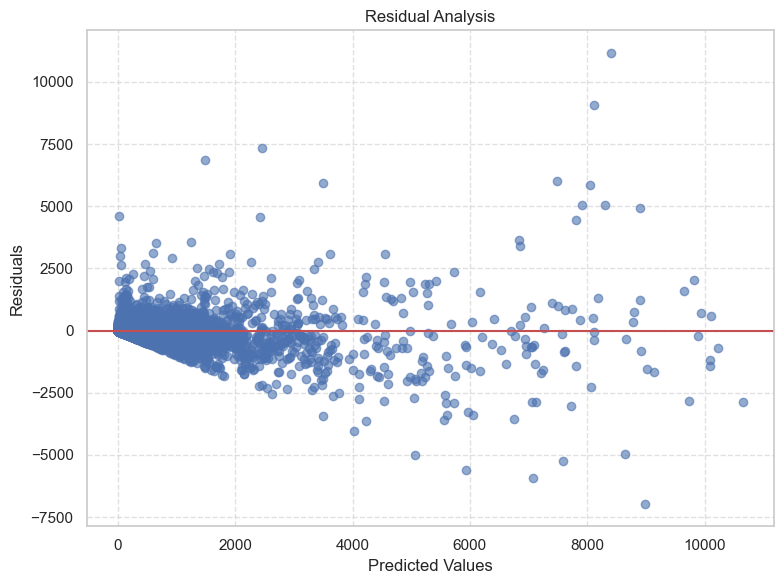

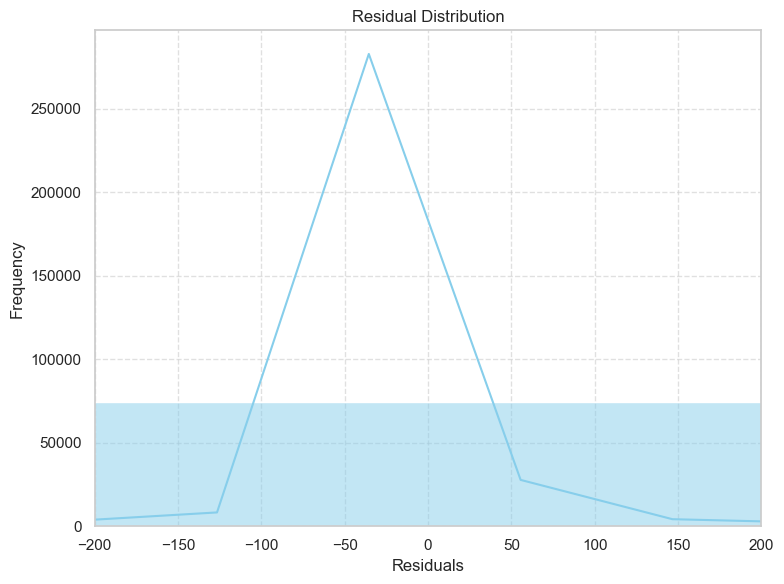

In [10]:
# Residual Analysis Scatter Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='b')
plt.title('Residual Analysis')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Residual Distribution Histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(-200, 200)  # Adjust the range as needed
plt.tight_layout()
plt.show()

There seem to be some potential outliers, particularly where the residuals are very high. Those situations may be worth investigating to see if they come from unusual datapoints

Let's explore a feature selection technique to potentially enhance our model's performance. This approach employs a method that intrigues me because it involves the use of 'shadow features' for comparison with our original features.

By leveraging this technique, we aim to identify which features are truly influential in our predictive model. This process can help us fine-tune our feature set, potentially leading to improved results.

In [14]:
# Apply Boruta to see if we can acquire better results
gbm = lgb.LGBMRegressor(**params, random_state=42, metric='L2')
feat_selector = BorutaPy(
    gbm, 
    n_estimators=500, 
    verbose=1, 
    max_iter=30, 
    alpha=0.1, 
    random_state=42
)
feat_selector.fit(X_train.values, y_train.values.ravel())

Iteration: 1 / 30
Iteration: 2 / 30
Iteration: 3 / 30
Iteration: 4 / 30
Iteration: 5 / 30
Iteration: 6 / 30
Iteration: 7 / 30
Iteration: 8 / 30
Iteration: 9 / 30
Iteration: 10 / 30
Iteration: 11 / 30
Iteration: 12 / 30
Iteration: 13 / 30
Iteration: 14 / 30
Iteration: 15 / 30
Iteration: 16 / 30
Iteration: 17 / 30
Iteration: 18 / 30
Iteration: 19 / 30
Iteration: 20 / 30
Iteration: 21 / 30
Iteration: 22 / 30
Iteration: 23 / 30
Iteration: 24 / 30
Iteration: 25 / 30
Iteration: 26 / 30
Iteration: 27 / 30
Iteration: 28 / 30
Iteration: 29 / 30


BorutaPy finished running.

Iteration: 	30 / 30
Confirmed: 	11
Tentative: 	0
Rejected: 	13


BorutaPy(alpha=0.1,
         estimator=LGBMRegressor(colsample_bytree=0.26542255346004306,
                                 learning_rate=0.018011774390702603,
                                 max_depth=56, metric='L2',
                                 min_split_gain=24.767406897306707,
                                 n_estimators=500, num_leaves=125,
                                 random_state=RandomState(MT19937) at 0x1D551392340,
                                 reg_alpha=0.9779312450176652,
                                 reg_lambda=0.7170224140564138,
                                 subsample=0.07855032863600003),
         max_iter=30, n_estimators=500,
         random_state=RandomState(MT19937) at 0x1D551392340, verbose=1)

In [17]:
cols = X_train.columns
selected_cols = cols[feat_selector.support_]

In [18]:
# Save the selected columns to a text file
with open('hypertuning/selected_columns.txt', 'w') as file:
    for col in selected_cols:
        file.write(f"{col}\n")

print(selected_cols)

Index(['add_to_wishlist', 'count_reviews', 'diff_days', 'conversion_rate',
       'discount_percentage', 'wishlist_to_pageviews_ratio',
       'cart_to_wishlist_ratio', 'add_to_wishlist_5d_rolling_avg',
       'add_to_cart_5d_rolling_avg', 'orders_5d_rolling_avg',
       'add_to_wishlist_1d_lag'],
      dtype='object')


Check the results by using only those variables

In [23]:
# Get the integer indices of the selected columns
X_train_selected = X_train[selected_cols.to_list()]
X_test_selected = X_test[selected_cols.to_list()]

gbm = lgb.LGBMRegressor(**params, random_state=42, metric='L2')
gbm.fit(X_train_selected, y_train)
y_pred = gbm.predict(X_test_selected)

In [24]:
# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)  # Calculate R-squared

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared (R²): {r_squared}')  # Print R-squared

RMSE: 182.81942501934688
MSE: 33422.942164404594
MAE: 34.414960409751245
R-squared (R²): 0.7733268640908759


We can see a slight decrease in the model's performance, but with the cost of a much faster computation since we managed to get rid of 13/24 variables.

### Ideas to maximize the potential of this project

- Consider Outliers in the Dataset: One potential factor to examine is the presence of outliers within our dataset. Outliers can significantly impact model performance and may need special handling or preprocessing.

- Examine Model's Generalization: Assess how well the model generalizes to unseen data. It's possible that the model is being evaluated on data that it hasn't encountered during training, leading to variations in performance.

- Analyze Data Patterns Post-January 1st: Observe the data patterns, especially after January 1st. Abrupt changes in patterns could be indicative of external factors or shifts in user behavior. Understanding these changes is crucial for improving predictions.

- Explore Data Enrichment: Consider data enrichment techniques. In a real-world scenario, additional data points or external data sources could provide valuable insights. These could include factors like holidays, special events, or economic indicators.

- Create New Variables: Explore the creation of new variables or features that could capture previously unnoticed patterns or relationships in the data. Feature engineering plays a significant role in improving model performance.

- Expand Model Selection Framework: Extend the search space for your model selection framework. Experiment with different algorithms or configurations to find the most suitable model for your problem.

- Increase Hyperparameter Tuning Iterations: Consider increasing the number of iterations for hyperparameter tuning. A more extensive search in the hyperparameter space may lead to finding better combinations that improve model performance.

- Re-Hypertune After Feature Selection: After performing feature selection, re-run the hyperparameter tuning process. Feature selection can alter the importance of different features, and re-hypertuning ensures that the model's hyperparameters are optimized for the reduced feature set.

### Further steps

- Containerization with Docker for ease of deployment and scalability, cloud platforms like AWS, Azure, and GCP for robust and scalable infrastructure.

- Continuous Integration/Continuous Deployment (CI/CD).

- Expand on using tools like MLflow for experiment tracking, model versioning, and lifecycle management.